# Getting the data ready for merger
In this section, the columns are filtered and duplicates are removed, preparing the data for merging with the other teammates' datasets.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.probability import FreqDist
from nltk.tokenize import *
import seaborn as sns
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler
import re
from bs4 import BeautifulSoup
from nltk.util import ngrams
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MultiLabelBinarizer
import spacy
from langdetect import detect
from nltk.corpus import words
from spellchecker import SpellChecker
import nltk
import contractions
import numpy as np

## Data undersatnding

In [2]:
filtered_data = pd.read_csv('testing_data.csv')

In [3]:
filtered_data.duplicated().sum()

0

In [4]:
filtered_data = filtered_data.drop_duplicates()
filtered_data.duplicated().sum()

0

In [5]:
filtered_data

,Unnamed: 0,overall_rating,review_date,review_text,airline_name
0,48188,Rated 1 out of 5 stars,"Monday, March 21, 2022 at 03:17:13 AM",I wrote to Pegasus about the frustrating issue...,pegasus airlines
1,41101,Rated 1 out of 5 stars,"Saturday, January 15, 2022 at 08:27:27 PM",DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair
2,75409,Rated 5 out of 5 stars,"Monday, September 11, 2023 at 09:13:10 PM",Useful,volotea
3,54218,Rated 1 out of 5 stars,"Thursday, June 29, 2023 at 06:48:40 AM",Ryanair cancelled my flight less than 24hrs be...,ryanair
4,15113,Rated 1 out of 5 stars,"Thursday, February 24, 2022 at 03:28:20 PM",It’s clear that BA are not even interested in ...,british airways
...,...,...,...,...,...
16431,61676,Rated 1 out of 5 stars,"Friday, October 13, 2017 at 03:03:16 AM",Worse than Ryanair. Enforces baggage weight re...,sas
16432,75438,Rated 5 out of 5 stars,"Sunday, September 10, 2023 at 06:38:14 PM",Useful,volotea
16433,79400,7.0,"April 1, 2022",Just What You Expect From. A Budget Airline. N...,Easyjet
16434,71018,Rated 1 out of 5 stars,"Monday, December 30, 2019 at 01:46:44 PM",Baggage handling is a MESS! They keep losing l...,united airlines


To come up with the target column 'NPS_score' we take scores 8 and above as promoters, and bellow as detractors and the rest as  neutral. The format of the data is also not consistent so we have to split the text to get the number for some records and scale up to 10 from 5 for others.

In [6]:
def classify_nps(rating_text):
    rating_text = rating_text.strip()
    if "Rated" in rating_text:
        rating = int(rating_text.split(' ')[1])
        return "Detractor" if rating <= 2 else ("Neutral" if rating == 3 else "Promoter")
    else:
        rating = int(float(rating_text))
        return "Detractor" if rating <= 6 else ("Neutral" if rating <= 8 else "Promoter")
        
print(classify_nps("7"))
print(classify_nps("Rated 4 out of 5 stars"))

filtered_data['NPS_score'] = filtered_data['overall_rating'].apply(classify_nps)


Neutral
Promoter


For the review_date column, we ended up having many different date type as the data was collected from many different websites, each having their own format. Thus the code bellow addresses the 3 different format that the 3 of us teammates have and convert into date type.

In [7]:
# Define functions to parse the three date formats
def parse_date_format1(date_str):
    try:
        return pd.to_datetime(date_str, format="%B %Y")
    except ValueError:
        return None

def parse_date_format2(date_str):
    try:
        return pd.to_datetime(date_str, format="%B %d, %Y")
    except ValueError:
        return None

def parse_date_format3(date_str):
    try:
        return pd.to_datetime(date_str, format="%A, %B %d, %Y at %I:%M:%S %p")
    except ValueError:
        return None

# Apply the parsing functions to the "review_date" column
parsed_dates = filtered_data["review_date"].apply(lambda x: parse_date_format1(x) or parse_date_format2(x) or parse_date_format3(x))

# Replace the "review_date" column with the parsed and standardized dates
filtered_data["review_date"] = parsed_dates

# Display the DataFrame with standardized dates
print(filtered_data)

       Unnamed: 0          overall_rating         review_date  \
0           48188  Rated 1 out of 5 stars 2022-03-21 03:17:13   
1           41101  Rated 1 out of 5 stars 2022-01-15 20:27:27   
2           75409  Rated 5 out of 5 stars 2023-09-11 21:13:10   
3           54218  Rated 1 out of 5 stars 2023-06-29 06:48:40   
4           15113  Rated 1 out of 5 stars 2022-02-24 15:28:20   
...           ...                     ...                 ...   
16431       61676  Rated 1 out of 5 stars 2017-10-13 03:03:16   
16432       75438  Rated 5 out of 5 stars 2023-09-10 18:38:14   
16433       79400                     7.0 2022-04-01 00:00:00   
16434       71018  Rated 1 out of 5 stars 2019-12-30 13:46:44   
16435       37954  Rated 1 out of 5 stars 2018-06-19 04:36:11   

                                             review_text      airline_name  \
0      I wrote to Pegasus about the frustrating issue...  pegasus airlines   
1      DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...       

Here is a simple bar graph to represent the number of missing (null) value in each of the columns. From below, we cans see that only the airline_name have some missing column.

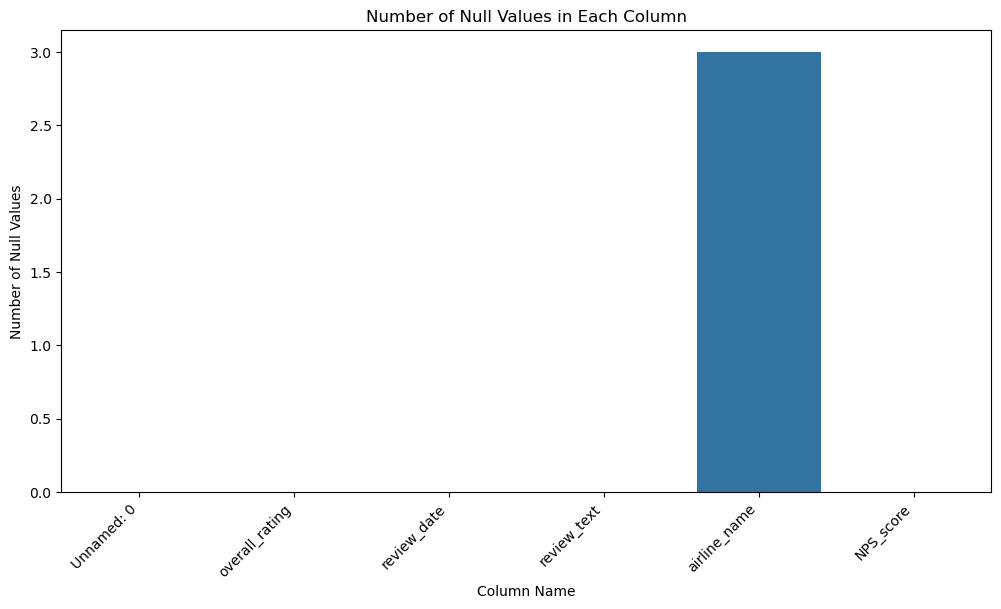

In [8]:
# Count the null values in each column
null_counts = filtered_data.isnull().sum()

# Set up the plot
plt.figure(figsize=(12, 6))
sns.barplot(x=null_counts.index, y=null_counts.values)
plt.title('Number of Null Values in Each Column')
plt.xlabel('Column Name')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

By taking length of the text data as a measurement, we can plot a box and whiskers graph that shows the outliers in the data. From bellow we can see that there are quite a few records that way outside the interquartile range, these records are known as outliers. Outliers are harmful to our models as they tend to be at the extreme and they cause the model to be unable to generalise the data well enough because of their extremes. Thus affecting the model's performance.

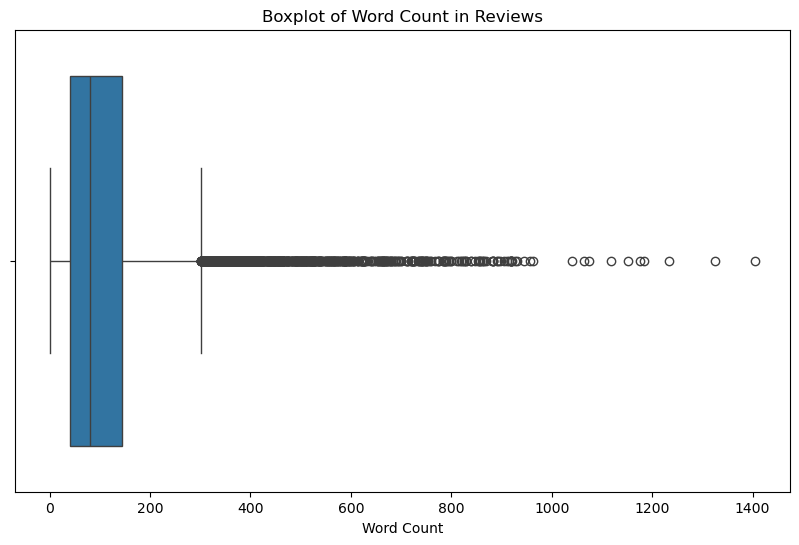

In [9]:
# Create a new column 'word_count' counting the number of words in each review
filtered_data['word_count'] = filtered_data['review_text'].apply(lambda x: len(str(x).split()))

# Plot a box and whiskers diagram for the 'word_count' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_data['word_count'])
plt.title('Boxplot of Word Count in Reviews')
plt.xlabel('Word Count')
plt.show()

From the bar graph we can tell that the most frequent words tend to be words that carry very little meaning in the context like 'the','and','a'. These words are called stopwords, these words produces noise in model buildin, affecting the model's performace in a negative way. Thus, it is important to treat stopwords in text data. This is important as this will cause the dimensionality of the TFIDF and Count vectoriser bag of words to increase, this could cause the model to take a longer time to load. 

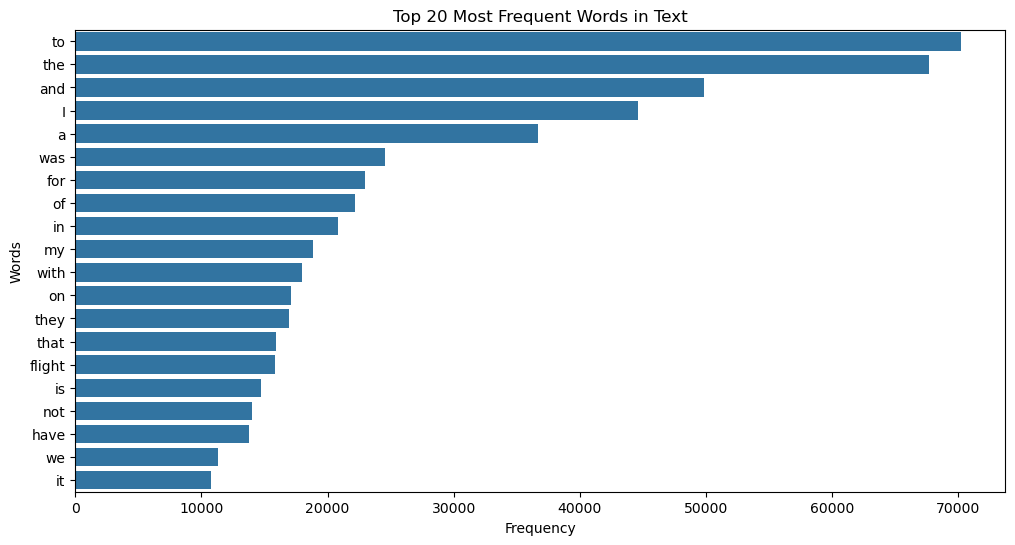

In [10]:
# Tokenize the text and count the frequency of each word
all_words = ' '.join(filtered_data['review_text']).split()
word_counts = Counter(all_words)

# Get the top N most frequent words (adjust as needed)
top_words_count = 20
top_words = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:top_words_count])

# Create a DataFrame with word counts
word_df = pd.DataFrame({'Words': list(top_words.keys()), 'Frequency': list(top_words.values())})

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Words', data=word_df)
plt.title(f'Top {top_words_count} Most Frequent Words in Text')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

We can see that consistently, there are more detractors than promoters over time. Notice there is a spike at 2023 to 2024, this can be because of the airlines trying to get back to normal from covid whcih casued their overall performace to decrease as they are not as used to as before covid.

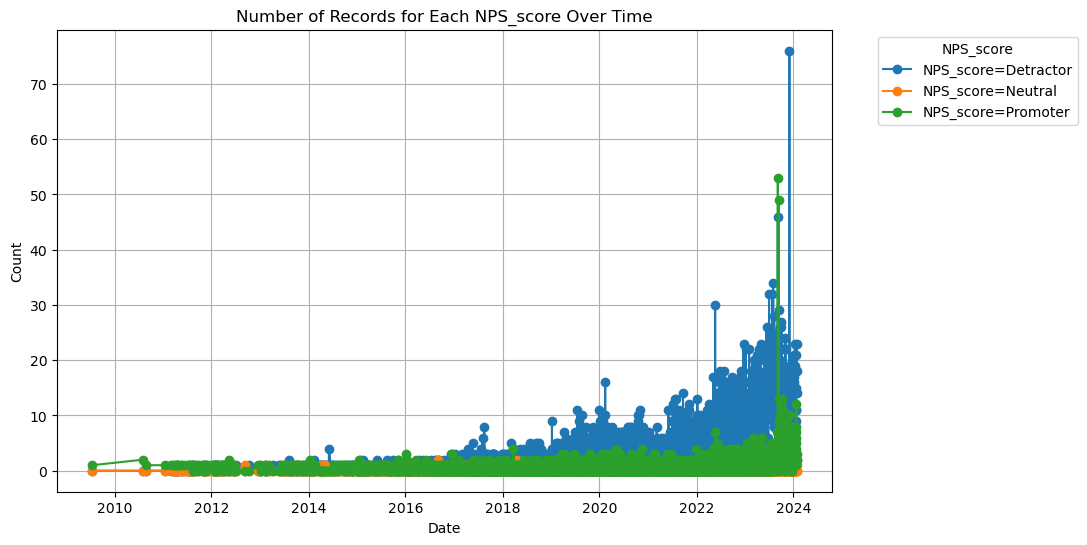

In [11]:
def plot_records_over_time(data, time_column, value_column, legend_column):
    grouped_data_size = data.groupby([pd.Grouper(key=time_column, freq='D'), legend_column]).size().unstack(fill_value=0)

    fig, ax = plt.subplots(figsize=(10, 6))

    for column in grouped_data_size.columns:
        ax.plot(grouped_data_size.index, grouped_data_size[column], marker='o', linestyle='-', label=f'{legend_column}={column}')

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=legend_column)

    ax.set_title(f'Number of Records for Each {legend_column} Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.grid(True)
    plt.show()

    
plot_records_over_time(filtered_data, 'review_date', 'NPS_score', 'NPS_score')


Our target column seems to have a imbalnce of data, there are more detractors than the two other classes combined. Imbalance in the target column classes can lead to a bias model. 

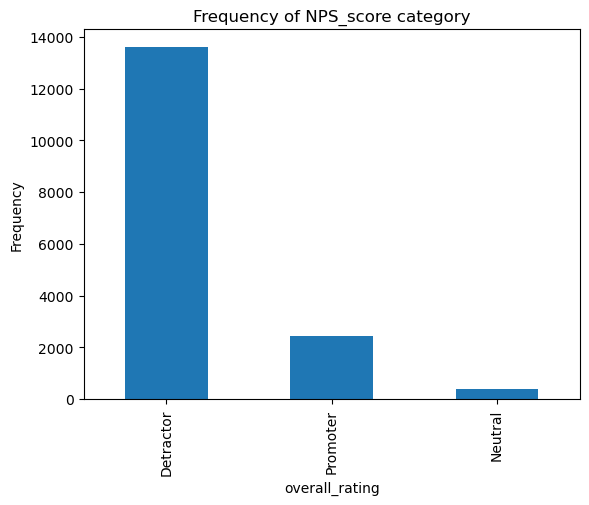

NPS_score
Detractor    13608
Promoter      2444
Neutral        384
Name: count, dtype: int64


In [12]:
stars = filtered_data['NPS_score'].value_counts()

stars.plot(kind='bar')
plt.title('Frequency of NPS_score category')
plt.xlabel('overall_rating')
plt.ylabel('Frequency')
plt.show()

print(stars)

This visual help us understand the presence of special charcters or html tags in the text. As we can see below, majority of the text contain these special characters. It is important that we deal with these characters as they can affect the model in a negative way by not preoviding any insghtful meaning to the model and at the same time create noise and confuse our models. Thus these characters need to be dealt with.

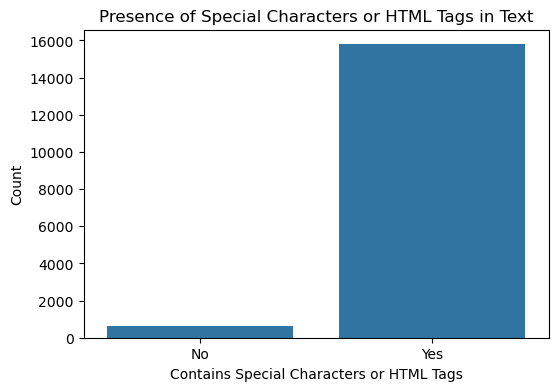

In [13]:
# Create a function to check for special characters or HTML tags
def has_special_characters_or_html(text):
    pattern = r'<[^>]+>|[^a-zA-Z0-9\s]'
    return bool(re.search(pattern, str(text)))

# Apply the function to check for special characters or HTML tags in the 'text' column
filtered_data['has_special_characters_or_html'] = filtered_data['review_text'].apply(has_special_characters_or_html)

# Create a bar plot to visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='has_special_characters_or_html', data=filtered_data)
plt.title('Presence of Special Characters or HTML Tags in Text')
plt.xlabel('Contains Special Characters or HTML Tags')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

We can see that some of the words here are in english yet they are on the word cloud, this can be due to there being special cheacters in the word casuing them to be there as seen before many of the records are affeted by these special characters. Other than that come words like 're' and 'c' are non english words.

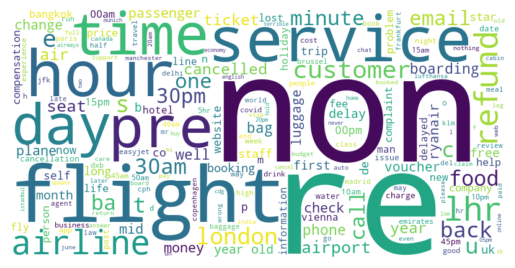

In [14]:
english_words = set(nltk.corpus.words.words())

# Assuming 'overall_rating' contains text data
filtered_data['not_english'] = filtered_data['review_text'].apply(lambda text: word_tokenize(text.lower()))

# Filter out non-English words
filtered_data['not_english'] = filtered_data['not_english'].apply(lambda word_list: [word for word in word_list if word not in english_words])

# Flatten the list of non-English words
unique_not_english = set(word for sublist in filtered_data['not_english'] for word in sublist)

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(unique_not_english))

# Plot WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Dealing with punctuation is also important as like stopwords, they do not really provide any information and just increases the dmensionality and create noise for the model. From the graph below, we can see that many of the text data are affected by the presence of the punctuations which has to be dealt with

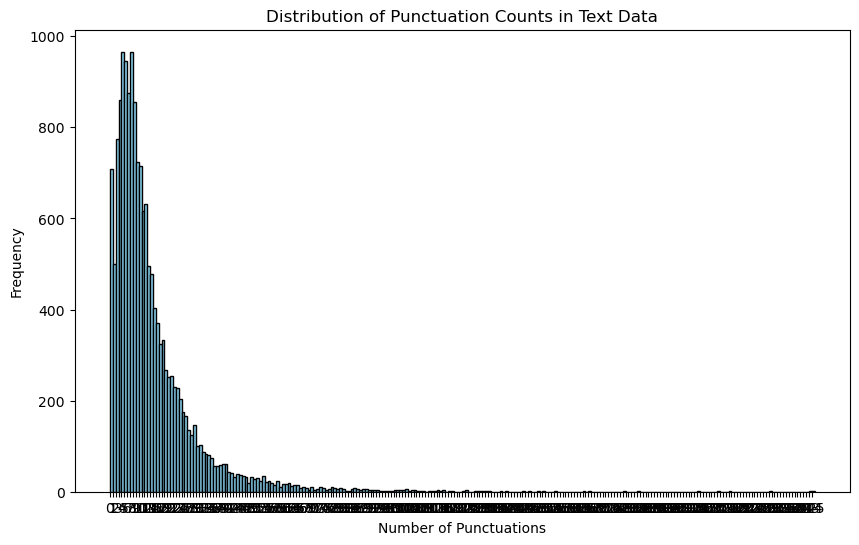

In [15]:
# Assuming 'data' is your DataFrame with a 'text' column
text_data = filtered_data['review_text']

# Function to count punctuation occurrences
def count_punctuations(text):
    return sum(1 for char in text if char in string.punctuation)

# Apply the function to each row in the 'text' column
filtered_data['punctuation_count'] = text_data.apply(count_punctuations)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['punctuation_count'], bins=range(max(filtered_data['punctuation_count']) + 2), color='skyblue', edgecolor='black')
plt.title('Distribution of Punctuation Counts in Text Data')
plt.xlabel('Number of Punctuations')
plt.ylabel('Frequency')
plt.xticks(range(max(filtered_data['punctuation_count']) + 1))

plt.show()

Mixed words are words that consists of both number and letters are shown to be present in the textual data. These words are harmful to the model as they disrupt the linguistic regularities and conventions typically found in natural language and create inconsistencies.

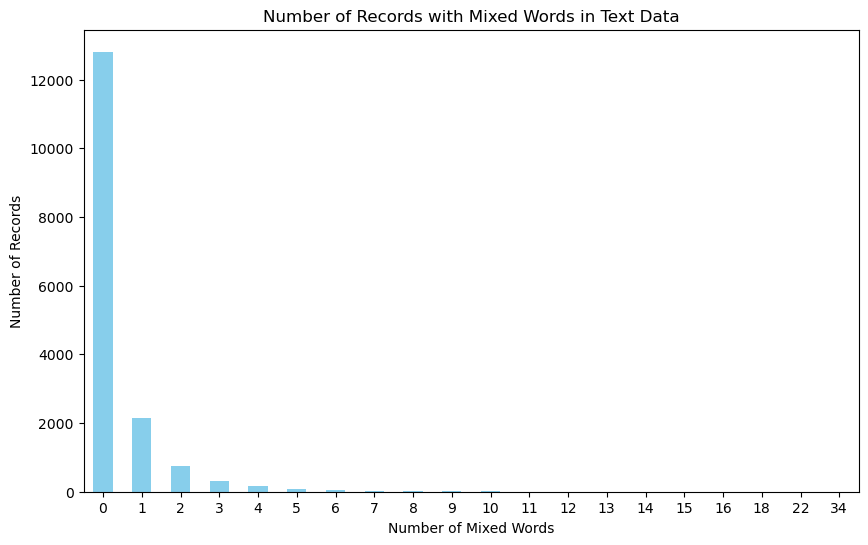

In [16]:
# Assuming 'data' is your DataFrame with a 'text' column
text_data = filtered_data['review_text']

# Function to count mixed words occurrences
def count_mixed_words(text):
    mixed_word_count = sum(1 for word in text.split() if re.search(r'\d', word) and re.search(r'[a-zA-Z]', word))
    return mixed_word_count

# Apply the function to each row in the 'text' column
filtered_data['mixed_word_count'] = text_data.apply(count_mixed_words)

# Count the number of records with mixed words
records_with_mixed_words = filtered_data['mixed_word_count'].value_counts().sort_index()

# Plot the bar graph
plt.figure(figsize=(10, 6))
ax = records_with_mixed_words.plot(kind='bar', color='skyblue')
plt.title('Number of Records with Mixed Words in Text Data')
plt.xlabel('Number of Mixed Words')
plt.ylabel('Number of Records')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

plt.show()

## Data Cleaning
- Removing duplicates (Done above)
- Remove Null values
- Outliers in text data
- Removal of stopwords and punctuations
- Removal of numbers and mixed words (numbers and letters)
- Lower casing
- Tokenize again using n-grams to define the compound words
- Lemmatize

Getting rid of null values

In [17]:
filtered_data.dropna(inplace=True)
filtered_data

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,mixed_word_count
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,0
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,0
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,0
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,1
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,0
...,...,...,...,...,...,...,...,...,...,...,...
16431,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,1
16432,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,0
16433,79400,7.0,2022-04-01 00:00:00,Just What You Expect From. A Budget Airline. N...,Easyjet,Neutral,32,True,"[., airline, ., seats, ,, chekcef, ,, ., .]",6,0
16434,71018,Rated 1 out of 5 stars,2019-12-30 13:46:44,Baggage handling is a MESS! They keep losing l...,united airlines,Detractor,13,True,"[!, luggages, ., !]",3,0


Getting rid of outliers

In [18]:
# Create a copy of the DataFrame
data_copy = filtered_data.copy()

# Calculate the IQR for the text length
Q1 = data_copy['review_text'].apply(len).quantile(0.25)
Q3 = data_copy['review_text'].apply(len).quantile(0.75)
IQR = Q3 - Q1

# Set a threshold for IQR to identify outliers
IQR_threshold = 1.5
lower_bound = Q1 - IQR_threshold * IQR
upper_bound = Q3 + IQR_threshold * IQR

# Create a new column 'removed_outliers' based on IQR
data_copy['removed_outliers'] = np.where((data_copy['review_text'].apply(len) >= lower_bound) & (data_copy['review_text'].apply(len) <= upper_bound), data_copy['review_text'], np.nan)

# Drop rows with NaN in the 'removed_outliers' column
data_copy = data_copy.dropna(subset=['removed_outliers'])

# Display the modified DataFrame
data_copy

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,mixed_word_count,removed_outliers
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,0,I wrote to Pegasus about the frustrating issue...
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,0,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,0,Useful
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,1,Ryanair cancelled my flight less than 24hrs be...
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,0,It’s clear that BA are not even interested in ...
...,...,...,...,...,...,...,...,...,...,...,...,...
16431,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,1,Worse than Ryanair. Enforces baggage weight re...
16432,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,0,Useful
16433,79400,7.0,2022-04-01 00:00:00,Just What You Expect From. A Budget Airline. N...,Easyjet,Neutral,32,True,"[., airline, ., seats, ,, chekcef, ,, ., .]",6,0,Just What You Expect From. A Budget Airline. N...
16434,71018,Rated 1 out of 5 stars,2019-12-30 13:46:44,Baggage handling is a MESS! They keep losing l...,united airlines,Detractor,13,True,"[!, luggages, ., !]",3,0,Baggage handling is a MESS! They keep losing l...


In [19]:
data_copy = data_copy.reset_index(drop=True)
data_copy

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,mixed_word_count,removed_outliers
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,0,I wrote to Pegasus about the frustrating issue...
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,0,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,0,Useful
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,1,Ryanair cancelled my flight less than 24hrs be...
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,0,It’s clear that BA are not even interested in ...
...,...,...,...,...,...,...,...,...,...,...,...,...
15342,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,1,Worse than Ryanair. Enforces baggage weight re...
15343,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,0,Useful
15344,79400,7.0,2022-04-01 00:00:00,Just What You Expect From. A Budget Airline. N...,Easyjet,Neutral,32,True,"[., airline, ., seats, ,, chekcef, ,, ., .]",6,0,Just What You Expect From. A Budget Airline. N...
15345,71018,Rated 1 out of 5 stars,2019-12-30 13:46:44,Baggage handling is a MESS! They keep losing l...,united airlines,Detractor,13,True,"[!, luggages, ., !]",3,0,Baggage handling is a MESS! They keep losing l...


Getting rid of special characters

In [20]:
# Define a function to remove everything except lowercase letters, numbers, and spaces using regex
def remove_non_alphanumeric(text):
    return re.sub(r'[^a-z0-9 ]+', '', text)

# Remove non-alphanumeric characters from the 'removed_outliers' column
data_copy['removed_punctuation'] = data_copy['removed_outliers'].apply(remove_non_alphanumeric)


data_copy

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,mixed_word_count,removed_outliers,removed_punctuation
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,0,I wrote to Pegasus about the frustrating issue...,wrote to egasus about the frustrating issues ...
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,0,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,moved my flight to different air...
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,1,Ryanair cancelled my flight less than 24hrs be...,yanair cancelled my flight less than 24hrs bef...
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,0,It’s clear that BA are not even interested in ...,ts clear that are not even interested in this...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,1,Worse than Ryanair. Enforces baggage weight re...,orse than yanair nforces baggage weight restri...
15343,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful
15344,79400,7.0,2022-04-01 00:00:00,Just What You Expect From. A Budget Airline. N...,Easyjet,Neutral,32,True,"[., airline, ., seats, ,, chekcef, ,, ., .]",6,0,Just What You Expect From. A Budget Airline. N...,ust hat ou xpect rom udget irline ot he est e...
15345,71018,Rated 1 out of 5 stars,2019-12-30 13:46:44,Baggage handling is a MESS! They keep losing l...,united airlines,Detractor,13,True,"[!, luggages, ., !]",3,0,Baggage handling is a MESS! They keep losing l...,aggage handling is a hey keep losing luggages...


Ensuring the data is consistent by lowercasing the text data

In [21]:
data_copy['lowercased'] = data_copy['removed_punctuation'].str.lower()
data_copy

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,mixed_word_count,removed_outliers,removed_punctuation,lowercased
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,0,I wrote to Pegasus about the frustrating issue...,wrote to egasus about the frustrating issues ...,wrote to egasus about the frustrating issues ...
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,0,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,moved my flight to different air...,moved my flight to different air...
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,1,Ryanair cancelled my flight less than 24hrs be...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled my flight less than 24hrs bef...
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,0,It’s clear that BA are not even interested in ...,ts clear that are not even interested in this...,ts clear that are not even interested in this...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,1,Worse than Ryanair. Enforces baggage weight re...,orse than yanair nforces baggage weight restri...,orse than yanair nforces baggage weight restri...
15343,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful
15344,79400,7.0,2022-04-01 00:00:00,Just What You Expect From. A Budget Airline. N...,Easyjet,Neutral,32,True,"[., airline, ., seats, ,, chekcef, ,, ., .]",6,0,Just What You Expect From. A Budget Airline. N...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot he est e...
15345,71018,Rated 1 out of 5 stars,2019-12-30 13:46:44,Baggage handling is a MESS! They keep losing l...,united airlines,Detractor,13,True,"[!, luggages, ., !]",3,0,Baggage handling is a MESS! They keep losing l...,aggage handling is a hey keep losing luggages...,aggage handling is a hey keep losing luggages...


Removing stopwords

In [22]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english')) - {'not', 'no'}
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Remove stopwords from the 'lowercased' column
data_copy['remove_stopwords'] = data_copy['lowercased'].apply(remove_stopwords)
data_copy

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,mixed_word_count,removed_outliers,removed_punctuation,lowercased,remove_stopwords
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,0,I wrote to Pegasus about the frustrating issue...,wrote to egasus about the frustrating issues ...,wrote to egasus about the frustrating issues ...,wrote egasus frustrating issues canceled fligh...
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,0,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,moved my flight to different air...,moved my flight to different air...,moved flight different airport phoned response...
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful,seful
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,1,Ryanair cancelled my flight less than 24hrs be...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled flight less 24hrs departs not...
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,0,It’s clear that BA are not even interested in ...,ts clear that are not even interested in this...,ts clear that are not even interested in this...,ts clear not even interested website rant wast...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,1,Worse than Ryanair. Enforces baggage weight re...,orse than yanair nforces baggage weight restri...,orse than yanair nforces baggage weight restri...,orse yanair nforces baggage weight restriction...
15343,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful,seful
15344,79400,7.0,2022-04-01 00:00:00,Just What You Expect From. A Budget Airline. N...,Easyjet,Neutral,32,True,"[., airline, ., seats, ,, chekcef, ,, ., .]",6,0,Just What You Expect From. A Budget Airline. N...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot est eats ...
15345,71018,Rated 1 out of 5 stars,2019-12-30 13:46:44,Baggage handling is a MESS! They keep losing l...,united airlines,Detractor,13,True,"[!, luggages, ., !]",3,0,Baggage handling is a MESS! They keep losing l...,aggage handling is a hey keep losing luggages...,aggage handling is a hey keep losing luggages...,aggage handling hey keep losing luggages nited


Removing numbers

In [23]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Remove numbers from the 'filtered_lowercased' column
data_copy['removed_numbers'] = data_copy['remove_stopwords'].apply(remove_numbers)

# Display the modified DataFrame
data_copy

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,mixed_word_count,removed_outliers,removed_punctuation,lowercased,remove_stopwords,removed_numbers
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,0,I wrote to Pegasus about the frustrating issue...,wrote to egasus about the frustrating issues ...,wrote to egasus about the frustrating issues ...,wrote egasus frustrating issues canceled fligh...,wrote egasus frustrating issues canceled fligh...
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,0,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,moved my flight to different air...,moved my flight to different air...,moved flight different airport phoned response...,moved flight different airport phoned response...
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful,seful,seful
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,1,Ryanair cancelled my flight less than 24hrs be...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled flight less 24hrs departs not...,yanair cancelled flight less hrs departs not a...
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,0,It’s clear that BA are not even interested in ...,ts clear that are not even interested in this...,ts clear that are not even interested in this...,ts clear not even interested website rant wast...,ts clear not even interested website rant wast...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,1,Worse than Ryanair. Enforces baggage weight re...,orse than yanair nforces baggage weight restri...,orse than yanair nforces baggage weight restri...,orse yanair nforces baggage weight restriction...,orse yanair nforces baggage weight restriction...
15343,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful,seful,seful
15344,79400,7.0,2022-04-01 00:00:00,Just What You Expect From. A Budget Airline. N...,Easyjet,Neutral,32,True,"[., airline, ., seats, ,, chekcef, ,, ., .]",6,0,Just What You Expect From. A Budget Airline. N...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot est eats ...,ust hat ou xpect rom udget irline ot est eats ...
15345,71018,Rated 1 out of 5 stars,2019-12-30 13:46:44,Baggage handling is a MESS! They keep losing l...,united airlines,Detractor,13,True,"[!, luggages, ., !]",3,0,Baggage handling is a MESS! They keep losing l...,aggage handling is a hey keep losing luggages...,aggage handling is a hey keep losing luggages...,aggage handling hey keep losing luggages nited,aggage handling hey keep losing luggages nited


Removing non-english words

In [24]:
def remove_non_english(text):
    tokens = word_tokenize(text.lower())  # Convert to lowercase before tokenization
    filtered_tokens = [word for word in tokens if word in english_words]
    return ' '.join(filtered_tokens)

# Remove non-English words from the 'removed_numbers' column
data_copy['english_only'] = data_copy['removed_numbers'].apply(remove_non_english)
data_copy

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,mixed_word_count,removed_outliers,removed_punctuation,lowercased,remove_stopwords,removed_numbers,english_only
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,0,I wrote to Pegasus about the frustrating issue...,wrote to egasus about the frustrating issues ...,wrote to egasus about the frustrating issues ...,wrote egasus frustrating issues canceled fligh...,wrote egasus frustrating issues canceled fligh...,wrote flight way flight way back no one even g...
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,0,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,moved my flight to different air...,moved my flight to different air...,moved flight different airport phoned response...,moved flight different airport phoned response...,flight different airport response take leave a...
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful,seful,seful,
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,1,Ryanair cancelled my flight less than 24hrs be...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled flight less 24hrs departs not...,yanair cancelled flight less hrs departs not a...,flight less not keep talking chat bot offer te...
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,0,It’s clear that BA are not even interested in ...,ts clear that are not even interested in this...,ts clear that are not even interested in this...,ts clear not even interested website rant wast...,ts clear not even interested website rant wast...,clear not even interested rant waste time effo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,1,Worse than Ryanair. Enforces baggage weight re...,orse than yanair nforces baggage weight restri...,orse than yanair nforces baggage weight restri...,orse yanair nforces baggage weight restriction...,orse yanair nforces baggage weight restriction...,baggage weight x often combined
15343,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful,seful,seful,
15344,79400,7.0,2022-04-01 00:00:00,Just What You Expect From. A Budget Airline. N...,Easyjet,Neutral,32,True,"[., airline, ., seats, ,, chekcef, ,, ., .]",6,0,Just What You Expect From. A Budget Airline. N...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot est eats ...,ust hat ou xpect rom udget irline ot est eats ...,ust hat eats ave ay rink ly gain
15345,71018,Rated 1 out of 5 stars,2019-12-30 13:46:44,Baggage handling is a MESS! They keep losing l...,united airlines,Detractor,13,True,"[!, luggages, ., !]",3,0,Baggage handling is a MESS! They keep losing l...,aggage handling is a hey keep losing luggages...,aggage handling is a hey keep losing luggages...,aggage handling hey keep losing luggages nited,aggage handling hey keep losing luggages nited,handling hey keep losing


Removing mixed words (words that contain both words and numbers)

In [25]:
def removed_mix(text):
    cleaned_text = re.sub(r'\b\w*[0-9]+\w*[a-zA-Z]+\w*\b', '', text)
    return cleaned_text

data_copy['removed_mix'] = data_copy['english_only'].apply(remove_non_english)
data_copy

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,mixed_word_count,removed_outliers,removed_punctuation,lowercased,remove_stopwords,removed_numbers,english_only,removed_mix
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,0,I wrote to Pegasus about the frustrating issue...,wrote to egasus about the frustrating issues ...,wrote to egasus about the frustrating issues ...,wrote egasus frustrating issues canceled fligh...,wrote egasus frustrating issues canceled fligh...,wrote flight way flight way back no one even g...,wrote flight way flight way back no one even g...
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,0,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,moved my flight to different air...,moved my flight to different air...,moved flight different airport phoned response...,moved flight different airport phoned response...,flight different airport response take leave a...,flight different airport response take leave a...
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful,seful,seful,,
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,1,Ryanair cancelled my flight less than 24hrs be...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled flight less 24hrs departs not...,yanair cancelled flight less hrs departs not a...,flight less not keep talking chat bot offer te...,flight less not keep talking chat bot offer te...
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,0,It’s clear that BA are not even interested in ...,ts clear that are not even interested in this...,ts clear that are not even interested in this...,ts clear not even interested website rant wast...,ts clear not even interested website rant wast...,clear not even interested rant waste time effo...,clear not even interested rant waste time effo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,1,Worse than Ryanair. Enforces baggage weight re...,orse than yanair nforces baggage weight restri...,orse than yanair nforces baggage weight restri...,orse yanair nforces baggage weight restriction...,orse yanair nforces baggage weight restriction...,baggage weight x often combined,baggage weight x often combined
15343,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful,seful,seful,,
15344,79400,7.0,2022-04-01 00:00:00,Just What You Expect From. A Budget Airline. N...,Easyjet,Neutral,32,True,"[., airline, ., seats, ,, chekcef, ,, ., .]",6,0,Just What You Expect From. A Budget Airline. N...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot est eats ...,ust hat ou xpect rom udget irline ot est eats ...,ust hat eats ave ay rink ly gain,ust hat eats ave ay rink ly gain
15345,71018,Rated 1 out of 5 stars,2019-12-30 13:46:44,Baggage handling is a MESS! They keep losing l...,united airlines,Detractor,13,True,"[!, luggages, ., !]",3,0,Baggage handling is a MESS! They keep losing l...,aggage handling is a hey keep losing luggages...,aggage handling is a hey keep losing luggages...,a

The following code first finds all the bigrams in the text data then create a count of all of the bigrams. Then take stop top 50 most frequently occuring bigrams and treat them as compound words and tokenize them together. This is to capture some context in the words to better help the model understand the text.

In [26]:
data_copy['bigram'] = data_copy['removed_mix'].apply(lambda x: list(ngrams(word_tokenize(x),2)))
data_copy

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,mixed_word_count,removed_outliers,removed_punctuation,lowercased,remove_stopwords,removed_numbers,english_only,removed_mix,bigram
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,0,I wrote to Pegasus about the frustrating issue...,wrote to egasus about the frustrating issues ...,wrote to egasus about the frustrating issues ...,wrote egasus frustrating issues canceled fligh...,wrote egasus frustrating issues canceled fligh...,wrote flight way flight way back no one even g...,wrote flight way flight way back no one even g...,"[(wrote, flight), (flight, way), (way, flight)..."
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,0,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,moved my flight to different air...,moved my flight to different air...,moved flight different airport phoned response...,moved flight different airport phoned response...,flight different airport response take leave a...,flight different airport response take leave a...,"[(flight, different), (different, airport), (a..."
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful,seful,seful,,,[]
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,1,Ryanair cancelled my flight less than 24hrs be...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled flight less 24hrs departs not...,yanair cancelled flight less hrs departs not a...,flight less not keep talking chat bot offer te...,flight less not keep talking chat bot offer te...,"[(flight, less), (less, not), (not, keep), (ke..."
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,0,It’s clear that BA are not even interested in ...,ts clear that are not even interested in this...,ts clear that are not even interested in this...,ts clear not even interested website rant wast...,ts clear not even interested website rant wast...,clear not even interested rant waste time effo...,clear not even interested rant waste time effo...,"[(clear, not), (not, even), (even, interested)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,1,Worse than Ryanair. Enforces baggage weight re...,orse than yanair nforces baggage weight restri...,orse than yanair nforces baggage weight restri...,orse yanair nforces baggage weight restriction...,orse yanair nforces baggage weight restriction...,baggage weight x often combined,baggage weight x often combined,"[(baggage, weight), (weight, x), (x, often), (..."
15343,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,0,Useful,seful,seful,seful,seful,,,[]
15344,79400,7.0,2022-04-01 00:00:00,Just What You Expect From. A Budget Airline. N...,Easyjet,Neutral,32,True,"[., airline, ., seats, ,, chekcef, ,, ., .]",6,0,Just What You Expect From. A Budget Airline. N...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot he est e...,ust hat ou xpect rom udget irline ot est eats ...,ust hat ou xpect rom udget irline ot est eats ...,ust hat eats ave ay rink ly gain,ust hat eats ave ay rink ly gain,"[(ust, hat), (hat, eats), (eats, ave

In [27]:
from collections import Counter

all_ngrams = [item for sublist in data_copy['bigram'] for item in sublist]

ngram_counts = Counter(all_ngrams)

ngram_list = list(ngram_counts.items())

sorted_ngram_list = sorted(ngram_list, key=lambda x: x[1], reverse=True)

sorted_ngram_list = sorted_ngram_list[0:100]

top_50_bigrams = [bigram[0] for bigram in sorted_ngram_list]

top_50_bigrams

[('customer', 'service'),
 ('return', 'flight'),
 ('could', 'not'),
 ('even', 'though'),
 ('business', 'class'),
 ('would', 'not'),
 ('no', 'one'),
 ('not', 'even'),
 ('booked', 'flight'),
 ('never', 'fly'),
 ('money', 'back'),
 ('flight', 'not'),
 ('get', 'refund'),
 ('flight', 'no'),
 ('another', 'flight'),
 ('next', 'day'),
 ('cabin', 'crew'),
 ('change', 'flight'),
 ('flight', 'due'),
 ('first', 'time'),
 ('flight', 'flight'),
 ('never', 'use'),
 ('not', 'fly'),
 ('next', 'flight'),
 ('worst', 'ever'),
 ('days', 'later'),
 ('not', 'get'),
 ('still', 'waiting'),
 ('dont', 'know'),
 ('experience', 'ever'),
 ('told', 'us'),
 ('trying', 'get'),
 ('credit', 'card'),
 ('book', 'flight'),
 ('not', 'able'),
 ('flight', 'time'),
 ('hey', 'not'),
 ('still', 'no'),
 ('hour', 'flight'),
 ('cancel', 'flight'),
 ('pay', 'extra'),
 ('last', 'minute'),
 ('get', 'money'),
 ('hand', 'luggage'),
 ('service', 'not'),
 ('new', 'flight'),
 ('service', 'ever'),
 ('dont', 'care'),
 ('boarding', 'pass'),
 

In [28]:
compound_words = top_50_bigrams
mwe_tokenizer = MWETokenizer(compound_words, separator='_')
data_copy['tokenized_chunking'] = data_copy['removed_mix'].apply(lambda x: mwe_tokenizer.tokenize(x.split()))
data_copy['tokenized_chunking'][78]

['lew', 'staff', 'professional', 'hank']

Lemmatizing data iis crucial when dealing with textual data as it normalizes words, simplifies feature extraction, and improves model generalization by reducing linguistic variations. Additionally, it creates consistency in vocabulary and enhanced interpretability. Thus, making lemmatization a crucial step for efficient and accurate language modeling.

In [29]:
# Define a function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Lemmatize the 'tokenized_column' column
data_copy['lemmatized_column'] = data_copy['tokenized_chunking'].apply(lemmatize_tokens)
data_copy

,Unnamed: 0,overall_rating,review_date,review_text,airline_name,NPS_score,word_count,has_special_characters_or_html,not_english,punctuation_count,...,removed_outliers,removed_punctuation,lowercased,remove_stopwords,removed_numbers,english_only,removed_mix,bigram,tokenized_chunking,lemmatized_column
0,48188,Rated 1 out of 5 stars,2022-03-21 03:17:13,I wrote to Pegasus about the frustrating issue...,pegasus airlines,Detractor,44,True,"[pegasus, frustrating, issues, canceled, ,, de...",4,...,I wrote to Pegasus about the frustrating issue...,wrote to egasus about the frustrating issues ...,wrote to egasus about the frustrating issues ...,wrote egasus frustrating issues canceled fligh...,wrote egasus frustrating issues canceled fligh...,wrote flight way flight way back no one even g...,wrote flight way flight way back no one even g...,"[(wrote, flight), (flight, way), (way, flight)...","[wrote, flight, way, flight, way_back, no_one,...","[wrote, flight, way, flight, way_back, no_one,..."
1,41101,Rated 1 out of 5 stars,2022-01-15 20:27:27,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,Detractor,87,True,"[n't, n't, called, airline, ,, 's, ,, moved, p...",7,...,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,moved my flight to different air...,moved my flight to different air...,moved flight different airport phoned response...,moved flight different airport phoned response...,flight different airport response take leave a...,flight different airport response take leave a...,"[(flight, different), (different, airport), (a...","[flight, different, airport, response, take, l...","[flight, different, airport, response, take, l..."
2,75409,Rated 5 out of 5 stars,2023-09-11 21:13:10,Useful,volotea,Promoter,1,False,[],0,...,Useful,seful,seful,seful,seful,,,[],[],[]
3,54218,Rated 1 out of 5 stars,2023-06-29 06:48:40,Ryanair cancelled my flight less than 24hrs be...,ryanair,Detractor,50,True,"[ryanair, cancelled, 24hrs, departs, answering...",5,...,Ryanair cancelled my flight less than 24hrs be...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled my flight less than 24hrs bef...,yanair cancelled flight less 24hrs departs not...,yanair cancelled flight less hrs departs not a...,flight less not keep talking chat bot offer te...,flight less not keep talking chat bot offer te...,"[(flight, less), (less, not), (not, keep), (ke...","[flight, less, not, keep, talking, chat, bot, ...","[flight, le, not, keep, talking, chat, bot, of..."
4,15113,Rated 1 out of 5 stars,2022-02-24 15:28:20,It’s clear that BA are not even interested in ...,british airways,Detractor,63,True,"[’, website, ,, ., stranded, airports, ., ryan...",6,...,It’s clear that BA are not even interested in ...,ts clear that are not even interested in this...,ts clear that are not even interested in this...,ts clear not even interested website rant wast...,ts clear not even interested website rant wast...,clear not even interested rant waste time effo...,clear not even interested rant waste time effo...,"[(clear, not), (not, even), (even, interested)...","[clear, not_even, interested, rant, waste, tim...","[clear, not_even, interested, rant, waste, tim..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,61676,Rated 1 out of 5 stars,2017-10-13 03:03:16,Worse than Ryanair. Enforces baggage weight re...,sas,Detractor,16,True,"[ryanair, ., enforces, restrictions, 10x, ryan...",2,...,Worse than Ryanair. Enforces baggage weight re...,orse than yanair nforces baggage weight restri...,orse than yanair nforces baggage weight restri...,orse yanair nforces baggage weight restriction...,orse yanair nforces baggage weight restriction...,baggage weight x often combined,baggage weight x often combined,"[(baggage, weight), (weight, x), (x, often), (...","[baggage, weight, x, often, combined]","[baggage, weight, x, often, combined]"
15343,75438,Rated 5 out of 5 stars,2023-09-10 18:38:14,Useful,volotea,Promoter,1,False,[],0,...

Final data

In [32]:
pre_data = data_copy[['overall_rating','NPS_score','review_text','remove_stopwords','removed_numbers','english_only','removed_mix','tokenized_chunking','lemmatized_column']]
pre_data

,overall_rating,NPS_score,review_text,remove_stopwords,removed_numbers,english_only,removed_mix,tokenized_chunking,lemmatized_column
0,Rated 1 out of 5 stars,Detractor,I wrote to Pegasus about the frustrating issue...,wrote egasus frustrating issues canceled fligh...,wrote egasus frustrating issues canceled fligh...,wrote flight way flight way back no one even g...,wrote flight way flight way back no one even g...,"[wrote, flight, way, flight, way_back, no_one,...","[wrote, flight, way, flight, way_back, no_one,..."
1,Rated 1 out of 5 stars,Detractor,DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,moved flight different airport phoned response...,moved flight different airport phoned response...,flight different airport response take leave a...,flight different airport response take leave a...,"[flight, different, airport, response, take, l...","[flight, different, airport, response, take, l..."
2,Rated 5 out of 5 stars,Promoter,Useful,seful,seful,,,[],[]
3,Rated 1 out of 5 stars,Detractor,Ryanair cancelled my flight less than 24hrs be...,yanair cancelled flight less 24hrs departs not...,yanair cancelled flight less hrs departs not a...,flight less not keep talking chat bot offer te...,flight less not keep talking chat bot offer te...,"[flight, less, not, keep, talking, chat, bot, ...","[flight, le, not, keep, talking, chat, bot, of..."
4,Rated 1 out of 5 stars,Detractor,It’s clear that BA are not even interested in ...,ts clear not even interested website rant wast...,ts clear not even interested website rant wast...,clear not even interested rant waste time effo...,clear not even interested rant waste time effo...,"[clear, not_even, interested, rant, waste, tim...","[clear, not_even, interested, rant, waste, tim..."
...,...,...,...,...,...,...,...,...,...
15342,Rated 1 out of 5 stars,Detractor,Worse than Ryanair. Enforces baggage weight re...,orse yanair nforces baggage weight restriction...,orse yanair nforces baggage weight restriction...,baggage weight x often combined,baggage weight x often combined,"[baggage, weight, x, often, combined]","[baggage, weight, x, often, combined]"
15343,Rated 5 out of 5 stars,Promoter,Useful,seful,seful,,,[],[]
15344,7.0,Neutral,Just What You Expect From. A Budget Airline. N...,ust hat ou xpect rom udget irline ot est eats ...,ust hat ou xpect rom udget irline ot est eats ...,ust hat eats ave ay rink ly gain,ust hat eats ave ay rink ly gain,"[ust, hat, eats, ave, ay, rink, ly, gain]","[ust, hat, eats, ave, ay, rink, ly, gain]"
15345,Rated 1 out of 5 stars,Detractor,Baggage handling is a MESS! They keep losing l...,aggage handling hey keep losing luggages nited,aggage handling hey keep losing luggages nited,handling hey keep losing,handling hey keep losing,"[handling, hey, keep, losing]","[handling, hey, keep, losing]"


Saving the data

In [33]:
pre_data.to_csv('test_preprocessed.csv', index=False)